In [1]:
import tracemalloc

from cov_3X2 import *
from lsst_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
colors=sns.color_palette()


In [2]:
import lsst_utils
import cov_3X2
import importlib
reload=importlib.reload
reload(lsst_utils)
reload(cov_3X2)
from lsst_utils import *
from cov_3X2 import *

In [3]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
worker_kwargs={'memory_spill_fraction':.75,'memory_target_fraction':.99,'memory_pause_fraction':1}
LC=LocalCluster(n_workers=1,processes=False,memory_limit='50gb',threads_per_worker=8,
                local_dir='/home/deep/repos/cosmic_shear/temp/NGL-worker/',
               **worker_kwargs,
                #scheduler_port=12234,
                diagnostics_port=8801
#                memory_monitor_interval='2000ms')
               )
client=Client(LC,diagnostics_port=8801,)

In [4]:
client

Client Scheduler: inproc://136.152.250.183/17240/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 8 Memory: 50.00 GB


In [5]:
nside=1024

In [6]:
#setup parameters
# lmax_cl=1000
lmax_cl=nside
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
# l_bins=np.int64(np.linspace(lmin_cl_Bins,lmax_cl_Bins,Nl_bins))
lb=(l_bins[1:]+l_bins[:-1])*.5

l=l0 #np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False

do_xi=False

In [7]:
use_window=True
f_sky=0.3
n_source_bins=1
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [8]:
store_win=True

(0.001, 1000.0)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


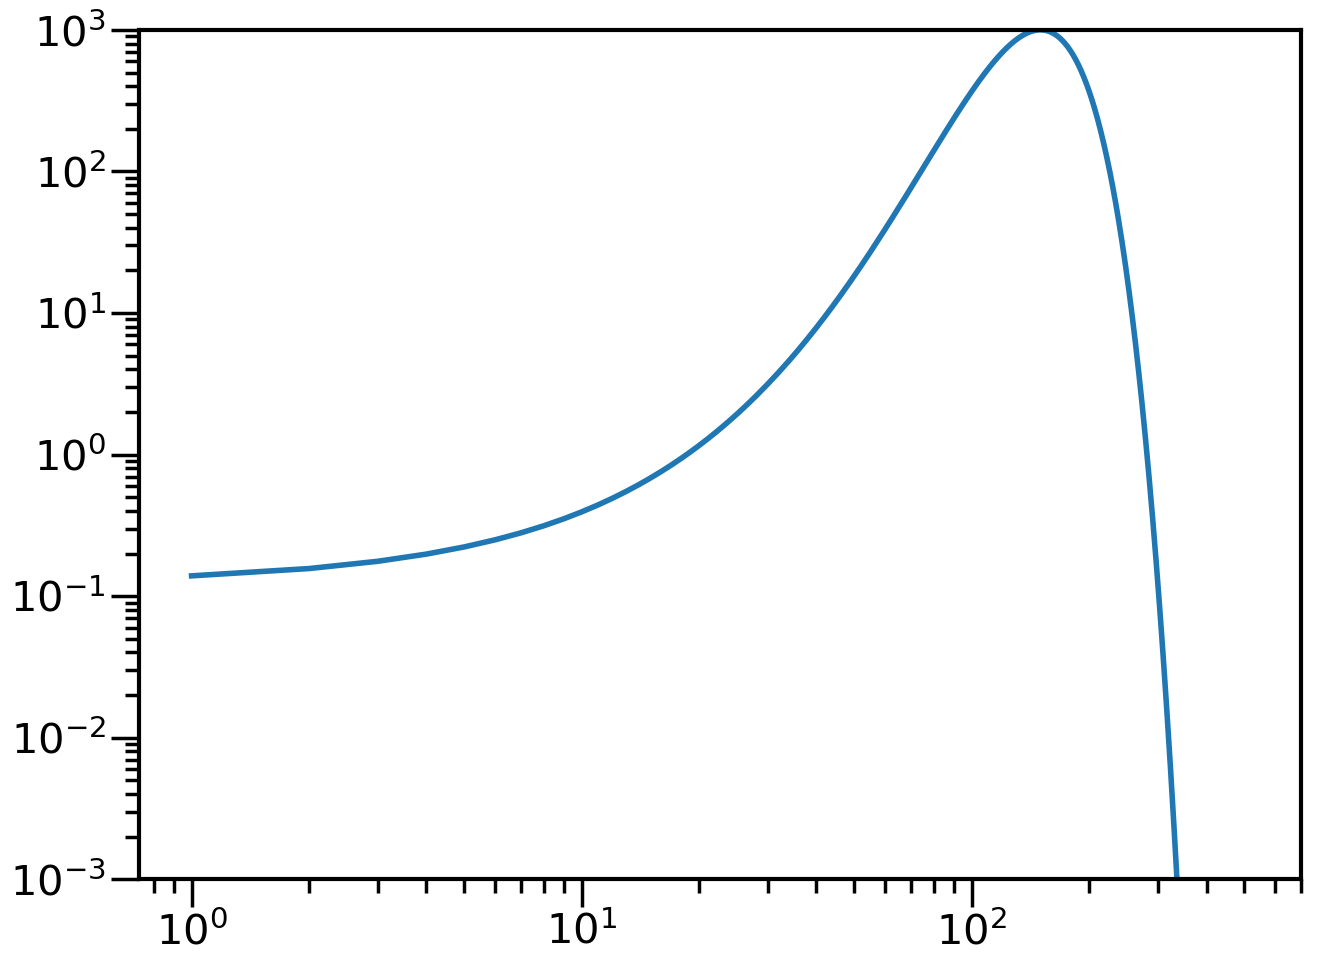

In [9]:
l0w=np.arange(512)+1
ww=1000*np.exp(-(l0w-150)**2/50**2)

loglog(l0w,ww)
ylim(1.e-3,1e3)

In [10]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')

In [11]:
z0=0.5
zl_bin1=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=10,use_window=use_window,nbins=1,window_cl_fact=0,
                         f_sky=f_sky,nside=nside,unit_win=True)
zl_bin1w=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,window_cl_fact=.1,#(1+ww/5),
                              f_sky=f_sky,nbins=n_source_bins,nside=nside)

ns0:  27.0


./cov_utils.py:62: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
ns0:  27.0
cl dict done


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [12]:
z0=1 #1087
zs_bin1=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,unit_win=False)

zs_bin1w=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,window_cl_fact=(1+ww),
                              f_sky=f_sky,nbins=n_source_bins,nside=nside)

ns0:  27.000000000000004
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
ns0:  27.000000000000004
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [14]:
th_min=1./60
th_max=600./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

# HT_kwargs={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
l0_win=np.arange(lmax_cl)
WT_L_kwargs={'l': l0_win,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
WT_L=None
if do_xi:
    %time WT_L=wigner_transform(**WT_L_kwargs)

In [15]:
bin_xi=True

In [16]:
import window_utils
reload(window_utils)
from window_utils import *

import tracer_utils
reload(tracer_utils)
from tracer_utils import *


import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [17]:
do_cov=True
store_win=True

In [18]:
corrs=[corr_ll,corr_ggl,corr_gg]
window_lmax=400

In [19]:
tracemalloc.clear_traces()
tracemalloc.start()


t1=time.time()
kappa_win=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                 #Win=kappa_win.Win.Win
                 )

t2=time.time()
print('W done',t2-t1)
%time clG_win=kappa_win.cl_tomo(corrs=corrs) 
%time cl0_win=clG_win['stack'].compute()

if do_xi:
    %time xiWG_L=kappa_win.xi_tomo()
    %time xiW_L=xiWG_L['stack'].compute()

wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.183/17240/1' processes=1 cores=8>
Cl windows done, now to covariance
W done 91.21204948425293
cl dict done
CPU times: user 16 s, sys: 110 ms, total: 16.1 s
Wall time: 7.73 s
CPU times: user 14 s, sys: 25.7 ms, total: 14.1 s
Wall time: 2.57 s


In [20]:
snapshot1 = tracemalloc.take_snapshot()

In [21]:
top_stats = snapshot1.statistics('lineno')
top_stats

[<Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/sparse/coo/core.py' lineno=234>,)> size=6364909560 count=54>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/sparse/coo/core.py' lineno=346>,)> size=1060820332 count=71>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=126>,)> size=420479696 count=18>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=380>,)> size=67109568 count=18>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=379>,)> size=67109504 count=16>,
 <Statistic traceback=<Traceback (<Frame filename='./window_utils.py' lineno=254>,)> size=25166064 count=6>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/numeric.py' lineno=1203>,)> size=10027344 count=9>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/einsumfunc.py' lineno=1346

In [22]:
stat = top_stats[3]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

18 memory blocks: 64.0 MiB
  File "./window_utils.py", line 380
    result0['M1423']={wp: np.zeros((nl,nl)) for wp in W_pm[1423]}


In [23]:
kappa_win.z_bins.keys()

dict_keys(['shear', 'galaxy'])

In [24]:
bi=(0,0)

In [25]:
R=kappa_win.Win.Win['cl'][corr_gg][bi]['M']/kappa_win.Win.Win['cl'][corr_ll][bi]['M']
R=np.nan_to_num(R)
x=R>0
R[x].max()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


1.7976931348623157e+308

In [26]:
kappa0=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi)

%time clG0=kappa0.cl_tomo(corrs=corrs) 
%time cl0=clG0['stack'].compute()

if do_xi:
    %time xiG_L0=kappa0.xi_tomo()
    %time xi_L0=xiG_L0['stack'].compute()

cl dict done
CPU times: user 15.9 s, sys: 105 ms, total: 16 s
Wall time: 7.67 s
CPU times: user 899 ms, sys: 2.41 ms, total: 901 ms
Wall time: 192 ms


In [27]:
bi=(0,0)
cl0={'cl_b':{},'cov':{}}
cl0_win_w={'cl_b':{},'cov':{}}
cl0_win={'cl_b':{},'cov':{}}
for corr in corrs:
    cl0['cl_b'][corr]=clG0['cl_b'][corr][bi].compute()
    cl0['cov'][corr]=clG0['cov'][corr+corr][bi+bi].compute()
    
    cl0_win['cl_b'][corr]=clG_win['cl_b'][corr][bi].compute()
    cl0_win['cov'][corr]=clG_win['cov'][corr+corr][bi+bi].compute()['final_b']
    
#     cl0_win_w['cl_b'][corr]=clG_win_w['cl_b'][corr][bi].compute()
#     cl0_win_w['cov'][corr]=clG_win_w['cov'][corr+corr][bi+bi].compute()['final_b']

In [28]:
mask=zs_bin1[0]['window']>-1.e-20

In [29]:
win2=zs_bin1[0]['window']/zs_bin1[0]['window']
win2[~mask]=hp.UNSEEN
win2[mask]=1.
cl_t2=hp.anafast(win2)

In [30]:
np.arange(len(cl_t2))

array([   0,    1,    2, ..., 3069, 3070, 3071])

In [31]:
def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))

In [32]:
def bin_coupling_M(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    Q=bin_M.T*np.pi*2/(l2)
    P=bin_M.T*(l2)/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [33]:
def bin_coupling_M2(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    
    Q=bin_M.T*np.pi*2/(l2)**2
    P=bin_M.T*(l2)**2/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [34]:
a=kappa_win.SN[corr_gg][(0,0)]*False
a

array([0.])

In [35]:
seed=12334
def get_clsim2(clg0,window,mask,kappa_class,coupling_M,coupling_M_inv,ndim,i):
    print(i)
    local_state = np.random.RandomState(seed+i)
    cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)

    if ndim>1:
        cl_map[0]*=window['galaxy']
        cl_map[0][mask['galaxy']]=hp.UNSEEN
        cl_map[1]*=window['shear'] #shear_1
        cl_map[2]*=window['shear']#shear_2
        cl_map[1][mask['shear']]=hp.UNSEEN
        cl_map[2][mask['shear']]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
        clpi=clpi[:,l]
        clpi=clpi[[0,1,3],:]
#             for i in np.arange(6):

    else:
        cl_map*=window
        cl_map[mask]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]
        
    del cl_map

    if ndim>1:
        clpi[0]-=(np.ones_like(clpi[0])*kappa_class.SN[corr_gg][:,0,0])@coupling_M[corr_gg]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M[corr_ll]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M['shear_B']*use_shot_noise #remove B-mode leakage

        clgi=[clpi[0]@coupling_M_inv[corr_gg],
              clpi[1]@coupling_M_inv[corr_ll],
              clpi[2]@coupling_M_inv[corr_ggl]]
    else:
        clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M
        clgi=clpi@coupling_M_inv
    clgi=np.array(clgi)
    return [clpi.T,clgi.T]



In [80]:
def calc_sim_stats(sim=[],sim_truth=[],PC=False):
    sim_stats={}
    sim_stats['std']=np.std(sim,axis=0)    
    sim_stats['mean']=np.mean(sim,axis=0)
    sim_stats['median']=np.median(sim,axis=0)
    sim_stats['percentile']=np.percentile(sim,[16,84],axis=0)
    sim_stats['skew']=skew(sim,axis=0)
    sim_stats['kurt']=kurtosis(sim,axis=0)
    sim_stats['cov']=np.cov(sim,rowvar=0)
    
    if not PC:
        try:
            sim_stats['cov_ev'],sim_stats['cov_evec']=np.linalg.eig(sim_stats['cov'])
            sim_stats['PC']={}
            sim_stats['PC']['data']=(sim_stats['cov_evec'].T@sim.T).T
            sim_stats['PC']['stats']=calc_sim_stats(sim=sim_stats['PC']['data'],PC=True)
        except Exception as err:
            print(err)
            sim_stats['PC']=err
    else:
        sim_truth=sim_stats['mean']
    
    sim_stats['percetile_score']=np.zeros_like(sim_stats['std'])
    if len(sim_stats['std'].shape)==1:
        for i in np.arange(len(sim_stats['std'])):
            sim_stats['percetile_score'][i]=percentileofscore(sim[:,i],sim_truth[i])
    elif len(sim_stats['std'].shape)==2:
        for i in np.arange(len(sim_stats['std'])):
            for i_dim in np.arange(2):
                for j_dim in np.arange(2):
                    sim_stats['percetile_score'][i][i_dim,j_dim]=percentileofscore(sim[:,i,i_dim,j_dim],
                                                                                   sim_truth[i,i_dim,j_dim])
    else:
        sim_stats['percetile_score']='not implemented for ndim>2'
    return sim_stats
    
def sim_cl_xi(Rsize=150,do_norm=False,cl0=None,kappa_class=None,fsky=f_sky,zbins=None,use_shot_noise=True,
             convolve_win=False,nside=nside):
    l=kappa_class.l
    shear_lcut=l>=2
    
    l_bins=kappa_class.l_bins
    dl=l_bins[1:]-l_bins[:-1]
    nu=(2.*l+1.)*fsky
    
    coupling_M={}
    coupling_M4={}
    coupling_M_binned={}
    coupling_M_binned2={}
    coupling_M4_binned={}
    coupling_M4_binned2={}
    
    coupling_M_inv={}
    coupling_M_binned_inv={}
    coupling_M_binned2_inv={}
    mask={}
    window={}
    if convolve_win:
        nu=2.*l+1.
        
        for tracer in kappa_class.z_bins.keys():
            window[tracer]=kappa_class.z_bins[tracer][0]['window']
            mask[tracer]=window[tracer]==hp.UNSEEN
        for corr in corrs:
            coupling_M[corr]=kappa_class.Win.Win['cl'][corr][(0,0)]['M']
            if corr==corr_ll:
                coupling_M['shear_B']=kappa_class.Win.Win['cl'][corr][(0,0)]['M_B']
            coupling_M_binned[corr]=bin_coupling_M(kappa_class,coupling_M[corr])
            coupling_M_binned2[corr]=kappa_class.binning.bin_2d(cov=coupling_M[corr],bin_utils=kappa_class.cl_bin_utils) 
            coupling_M_binned2[corr]*=dl
            
#             coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
#             coupling_M4_binned[corr]=bin_coupling_M(kappa_class,coupling_M4[corr])
#             coupling_M4_binned2[corr]=kappa_class.binning.bin_2d(cov=coupling_M4[corr],bin_utils=kappa_class.cl_bin_utils) 
#             coupling_M4_binned2[corr]*=dl
#         kappa_class.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils)
#             print(corr,coupling_M[corr])
            
            cut=l>0
            if 'shear' in corr:
                cut=shear_lcut 
            coupling_M_inv[corr]=np.zeros_like(coupling_M[corr])
            coupling_M_inv[corr][:,cut][cut,:]=np.linalg.inv(coupling_M[corr][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
            
            coupling_M_binned_inv[corr]=np.linalg.inv(coupling_M_binned[corr])
            coupling_M_binned2_inv[corr]=np.linalg.inv(coupling_M_binned2[corr])
    outp={}
    win=0
    if cl0 is None:
        cl0={}
        clp0={}
        clG0=kappa_class.cl_tomo() 
        for corr in kappa_class.corrs:
            cl0[corr]=clG0['cl'][corr][(0,0)].compute()
            clp0[corr]=clG0['cl_b'][corr][(0,0)].compute()
    clg0={}
    for corr in kappa_class.corrs: #ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
        shot_noise=0
        if corr[0]==corr[1]:
            shot_noise=kappa_class.SN[corr][:,0,0]
        shot_noise*=use_shot_noise
        clg0[corr]=cl0[corr]+shot_noise
        if corr==('shear','shear'):
            clg0['shear_B']=cl0[corr]*0+shot_noise
    ndim=len(kappa_class.corrs)
    print('ndim:',ndim)
    outp['clg0_0']=clg0.copy()
    outp['ndim']=ndim
    if ndim>1:
        clg0=(clg0[corr_gg],clg0[corr_ll],clg0['shear_B'],clg0[corr_ggl])#ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
    else:
        clg0=clg0[corr_gg]
    
    SN=kappa_class.SN
    sim_cl_shape=(Rsize,len(kappa_class.l),ndim)
    clp=np.zeros(sim_cl_shape,dtype='float32')
    clg=np.zeros(sim_cl_shape,dtype='float32')
    lmax=max(l)
    lmin=min(l)
    
    seed=12334
    def get_clsim(i):
        print('doing map: ',i)
        local_state = np.random.RandomState(seed+i)
        cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)
        
        if ndim>1:
            cl_map[0]*=window['galaxy']
            cl_map[0][mask['galaxy']]=hp.UNSEEN
            cl_map[1]*=window['shear'] #shear_1
            cl_map[2]*=window['shear']#shear_2
            cl_map[1][mask['shear']]=hp.UNSEEN
            cl_map[2][mask['shear']]=hp.UNSEEN
            clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
            clpi=clpi[:,l]
            clpi=clpi[[0,1,3],:]
#             for i in np.arange(6):
            
            
        else:
            cl_map*=window
            cl_map[mask]=hp.UNSEEN
            clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]

        if ndim>1:
            clpi[0]-=(np.ones_like(clpi[0])*SN[corr_gg][:,0,0])@coupling_M[corr_gg]*use_shot_noise
            clpi[1]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M[corr_ll]*use_shot_noise
            clpi[1]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M['shear_B']*use_shot_noise #remove B-mode leakage
            
            clgi=[clpi[0]@coupling_M_inv[corr_gg],
                  clpi[1]@coupling_M_inv[corr_ll],
                  clpi[2]@coupling_M_inv[corr_ggl]]
        else:
            clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M
            clgi=clpi@coupling_M_inv
        clgi=np.array(clgi)
        return clpi.T,clgi.T
    
    def comb_maps(futures):
        for i in np.arange(Rsize):
            x=futures[i]#.compute()
            clp[i,:,:]+=x[0]
            clg[i,:,:]+=x[1]
        return clp,clg 
    
    print('generating maps')
    if convolve_win:
        futures={}
#         for i in np.arange(Rsize):
#             futures[i]=dask.delayed(get_clsim)(i)  
#         print(futures)
#         clpg=dask.delayed(comb_maps)(futures)
#         clpg.compute()
        i=0
        j=0
        step=10 # min(10,Rsize)
        funct=partial(get_clsim2,clg0,window,mask,SN,coupling_M,coupling_M_inv,ndim)
#         x=funct(1)
#         print(x)
        print('step: ',step)
        while j<Rsize:
            futures={}
#         for j in np.arange(Rsize/1):
#             pool=Pool(5)
#             i_iter=np.arange(step)+i
#             futures=pool.map(funct,i_iter)
#             pool.close()
            for ii in np.arange(step):
#               futures[ii]=client.submit(get_clsim,i+ii)  
                futures[ii]=delayed(get_clsim)(i+ii)  
    #         r=client.gather(futures)
    #         futures=client.map(get_clsim,np.arange(Rsize))
            print('done submits: ',i)
            futures=client.compute(futures)
            for ii in np.arange(step):
                clp[i,:],clg[i,:]=futures.result()[ii]
#                 clp[i,:],clg[i,:]=#client.submit(get_clsim,i)
#                 clp[i,:]=futures[ii][0]
#                 clg[i,:]=futures[ii][1]
#                 futures[ii]=None
                i+=1
            print('done map ',i)
            del futures
            client.restart()
            j+=step
        
    print('done generating maps')
    
    clg_b=None
    clp_b=None
    nu_b=None
    if l_bins is not None:
        clg0_b={corr: kappa_class.binning.bin_1d(xi=cl0[corr],bin_utils=kappa_class.cl_bin_utils) for corr in kappa_class.corrs} 
        ll=kappa_class.cl_bin_utils['bin_center']
        sim_clb_shape=(Rsize,len(ll),ndim)
        nu_b=(2.*ll+1.)*fsky*(l_bins[1:]-l_bins[:-1])
        clg_b=np.zeros(sim_clb_shape,dtype='float32')
        clg_b2=np.zeros(sim_clb_shape,dtype='float32')
        clg_b22=np.zeros(sim_clb_shape,dtype='float32')
        clp_b=np.zeros(sim_clb_shape,dtype='float32')
        
        corr_t=[corr_gg,corr_ll,corr_ggl]
        for i in np.arange(Rsize):
            for ii in np.arange(ndim):
                clg_b[i,:,ii]=kappa_class.binning.bin_1d(xi=clg[i,:,ii],bin_utils=kappa_class.cl_bin_utils)
                clp_b[i,:,ii]=kappa_class.binning.bin_1d(xi=clp[i,:,ii],bin_utils=kappa_class.cl_bin_utils)
                clg_b2[i,:,ii]=clp_b[i,:,ii]@coupling_M_binned_inv[corr_t[ii]]
                clg_b22[i,:,ii]=clp_b[i,:,ii]@coupling_M_binned2_inv[corr_t[ii]]
            
        outp['clg_b_stats']={corr_t[ii]: calc_sim_stats(sim=clg_b[:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)}
        outp['clg_b2_stats']={corr_t[ii]: calc_sim_stats(sim=clg_b2[:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)}
        outp['clg_b22_stats']={corr_t[ii]: calc_sim_stats(sim=clg_b22[:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)}
        outp['clp_b_stats']={corr_t[ii]: calc_sim_stats(sim=clp_b[:,:,ii],sim_truth=clp_b[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)}
#         outp['clp_b_stats']=calc_sim_stats(sim=clp_b,sim_truth=clp_b.mean(axis=0))
#     xiN=np.zeros((Rsize,len(xi)))
#     xig=np.zeros((Rsize,len(xi)))
#     xigB=np.zeros((Rsize,len(r_bins)-1))
#     xiNB=np.zeros((Rsize,len(r_bins)-1))
#     for i in np.arange(Rsize):
#         r,xig[i,:]=HT.projected_correlation(k_pk=l,pk=clg[i,:],j_nu=0,taper=True,**taper_kw)
#         rb,xigB[i,:]=HT.bin_mat(r=r,mat=xig[i,:],r_bins=r_bins)
#         if do_clN:
#             r,xiN[i,:]=HT.projected_correlation(k_pk=l,pk=clN[i,:],j_nu=0,taper=True,**taper_kw)
#             rb,xiNB[i,:]=HT.bin_mat(r=r,mat=xiN[i,:],r_bins=r_bins)
#     outp['xi_truth']=xi_truth
#    outp['rb']=rb
    outp['clg']=clg
    outp['clp']=clp
    outp['clg_b']=clg_b
    outp['clg_b2']=clg_b2
    outp['clg_b22']=clg_b22
    outp['clp_b']=clp_b
    outp['clg0']=clg0
    outp['cl0']=cl0
    outp['clp0']=clp0
#     outp['clN']=clN
#     outp['xig']=xig
#     outp['xigB']=xigB
#     outp['xiNB']=xiNB
#     outp['xiN']=xiN
    print(clg[:,:,ii])
    clg0_2=np.array(clg0)[[0,1,3],:]
    outp['clg_stats']={corr_t[ii]: calc_sim_stats(sim=clg[:,:,ii],sim_truth=clg0_2[ii]) for ii in np.arange(ndim)}#calc_sim_stats(sim=clg,sim_truth=clg0)
    outp['clp_stats']={corr_t[ii]: calc_sim_stats(sim=clp[:,:,ii],sim_truth=clp[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)}#     calc_sim_stats(sim=clp,sim_truth=clp.mean(axis=0))

#     outp['xig_stats']=calc_sim_stats(sim=xig,sim_truth=xi)
#     if convolve_win:
#         outp['xig_stats0']=calc_sim_stats(sim=xig,sim_truth=xi0)
#     rb,xiB=HT.bin_mat(r=r,mat=xi_truth,r_bins=r_bins)
#     outp['xigB_stats']=calc_sim_stats(sim=xigB,sim_truth=xiB)
#     if do_clN:
#         outp['xiN_stats']=calc_sim_stats(sim=xiN,sim_truth=xi_truth)
#         outp['xiNB_stats']=calc_sim_stats(sim=xiNB,sim_truth=xiB)

    outp['size']=Rsize
    outp['fsky']=fsky
    outp['nu']=nu
    outp['nu_b']=nu_b
    outp['l_bins']=l_bins
    
    outp['coupling_M']=coupling_M
    outp['coupling_M_binned']=coupling_M_binned
    outp['coupling_M_binned2']=coupling_M_binned2
    
    outp['coupling_M_inv']=coupling_M_inv
    outp['coupling_M_binned_inv']=coupling_M_binned_inv
    outp['coupling_M_binned2_inv']=coupling_M_binned2_inv
    outp['use_shot_noise']=use_shot_noise
    
    
    return outp

#cov=np.diag(cl**2/nu)

In [81]:
clg0=clG0['cl'][corrs[0]][(0,0)].compute()

In [82]:
client.restart()

Client Scheduler: inproc://136.152.250.183/17240/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 8 Memory: 50.00 GB


In [83]:
shot_noise=kappa_win.SN[corrs[0]][0,0,0]

In [84]:
nsim=100

In [85]:
nsim

10

In [86]:
use_shot_noise=True

In [87]:
tracemalloc.clear_traces()
tracemalloc.start()
cl_sim_W=sim_cl_xi(Rsize=nsim,do_norm=False,#cl0=clG0['cl'][corrs[0]][(0,0)].compute(),
          kappa_class=kappa_win,fsky=f_sky,use_shot_noise=use_shot_noise,
             convolve_win=True,nside=nside)
snapshot1 = tracemalloc.take_snapshot()

cl dict done
ndim: 3
generating maps
step:  10
done submits:  0
doing map:  0
doing map:  2
doing map: doing map: doing map:  3
 6
doing map:  5
doing map:  7
 4
doing map:  9
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 

-> fwhm is 0.000000 arcmin
-> fwhm is 0.000000 arcmin
doing map:  1
doing map:  8
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done map  10
done generating maps
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [

distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.183/17240/20 remote=inproc://136.152.250.183/17240/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc local=inproc://136.152.250.183/17240/21 remote=inproc://136.152.250.183/17240/1>


In [88]:
snapshot1 = tracemalloc.take_snapshot()

In [89]:
top_stats = snapshot1.statistics('lineno')
top_stats

[<Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/lib/function_base.py' lineno=2450>,)> size=126234920 count=115>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/linalg/linalg.py' lineno=1311>,)> size=101056512 count=60>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/numeric.py' lineno=168>,)> size=25242672 count=54>,
 <Statistic traceback=<Traceback (<Frame filename='/home/deep/repos/cosmic_shear/power_spectra.py' lineno=277>,)> size=8002536 count=103>,
 <Statistic traceback=<Traceback (<Frame filename='/home/deep/repos/cosmic_shear/power_spectra.py' lineno=342>,)> size=4000080 count=2>,
 <Statistic traceback=<Traceback (<Frame filename='/home/deep/repos/cosmic_shear/power_spectra.py' lineno=332>,)> size=4000080 count=2>,
 <Statistic traceback=<Traceback (<Frame filename='./tracer_utils.py' lineno=178>,)> size=1638720 count=6>,
 <Statistic traceback=<Trac

In [90]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

115 memory blocks: 120.4 MiB
  File "/usr/lib/python3.7/site-packages/numpy/lib/function_base.py", line 2450
    c = dot(X, X_T.conj())


In [68]:
client.restart()

Client Scheduler: inproc://136.152.250.183/17240/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 8 Memory: 50.00 GB


In [ ]:
import pickle

In [ ]:
fname='./tests/non_gaussian_likeli_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'.pkl'
if not use_shot_noise:
    fname='./tests/non_gaussian_likeli_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_noSN.pkl'
outp={}
outp['simW']=cl_sim_W
outp['simWw']=cl_sim_Ww
outp['zs_bin1']=zs_bin1
outp['zs_bin1w']=zs_bin1w
outp['zl_bin1']=zl_bin1
outp['zl_bin1w']=zl_bin1w
outp['cl0']=cl0
outp['cl0_win_w']=cl0_win_w
outp['cl0_win']=cl0_win

with open(fname,'wb') as f:
    pickle.dump(outp,f)

In [92]:
# # fname='./tests/non_gaussian_likeli_sims_'+str(nside)+'.pkl'
# # with open(fname, 'rb') as handle:
# #     outp = pickle.load(handle)

# cl_sim_W=outp['simW']
# cl_sim_Ww=outp['simWw']
# zs_bin1=outp['zs_bin1']
# zs_bin1w=outp['zs_bin1w']
# zl_bin1=outp['zl_bin1']
# zl_bin1w=outp['zl_bin1w']
# cl0=outp['cl0']
# cl0_win_w=outp['cl0_win_w']
# cl0_win=outp['cl0_win']



In [93]:
()+corr_gg

('galaxy', 'galaxy')

In [94]:
corr=corr_ll
bi=(0,0)

In [95]:
labels={}
labels[corr_gg]=r'$gg$'
labels[corr_ll]=r'$\gamma\gamma$'
labels[corr_ggl]=r'$g \gamma$'

(1e-08, 0.001)

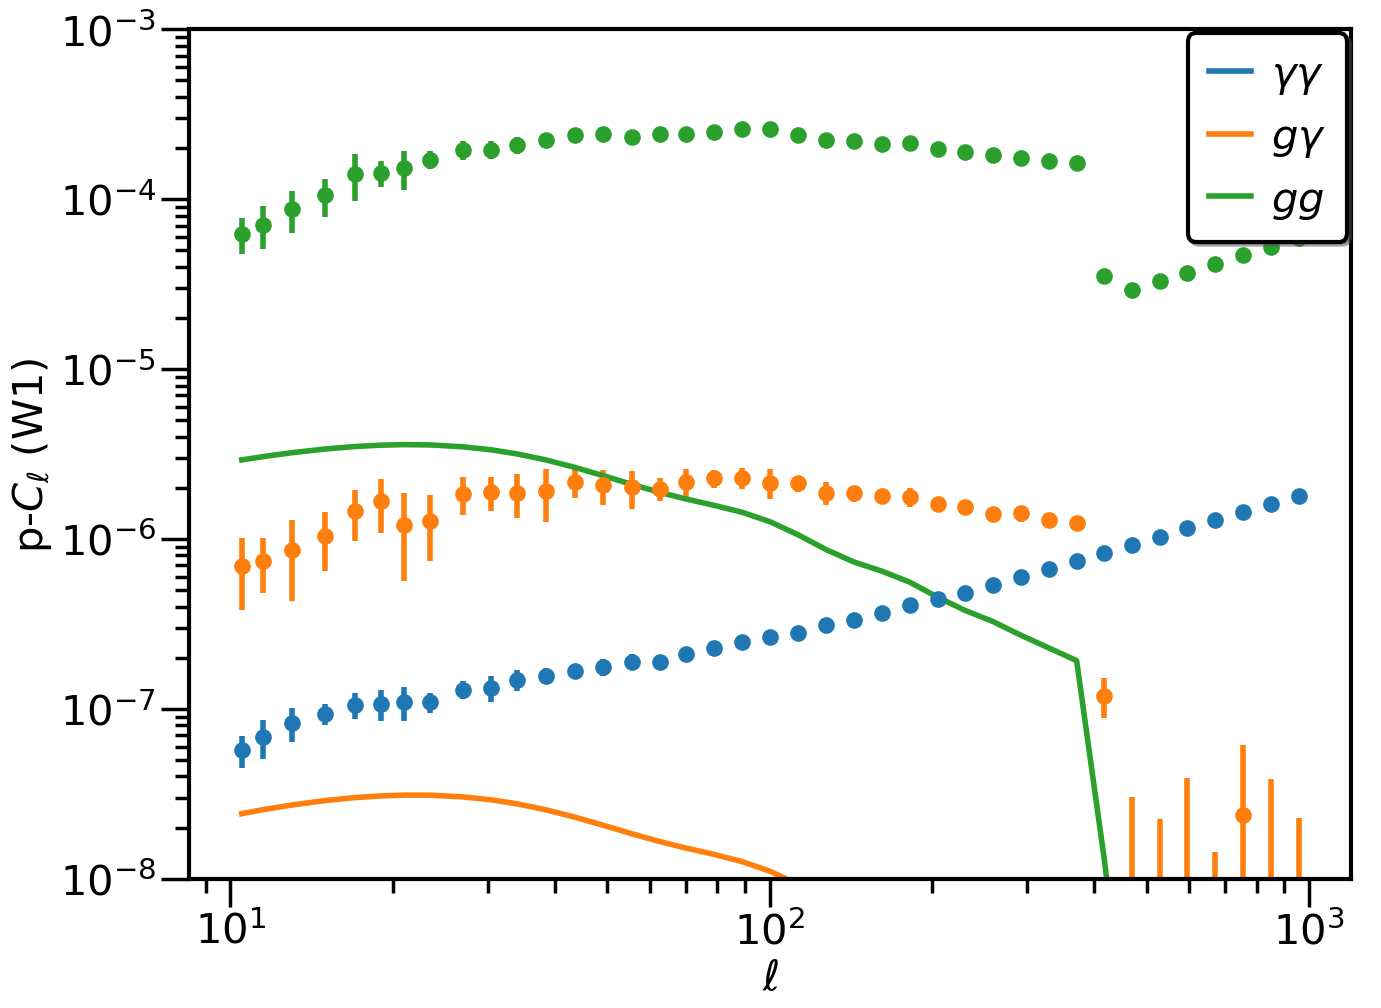

In [104]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_W['clp_b_stats'][corr]['mean'],f*cl_sim_W['clp_b_stats'][corr]['std'],fmt='o',c=color)
    plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()
ylim(1.e-8,1.e-3)

In [97]:
kappa_win.Win.window_l

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

[]

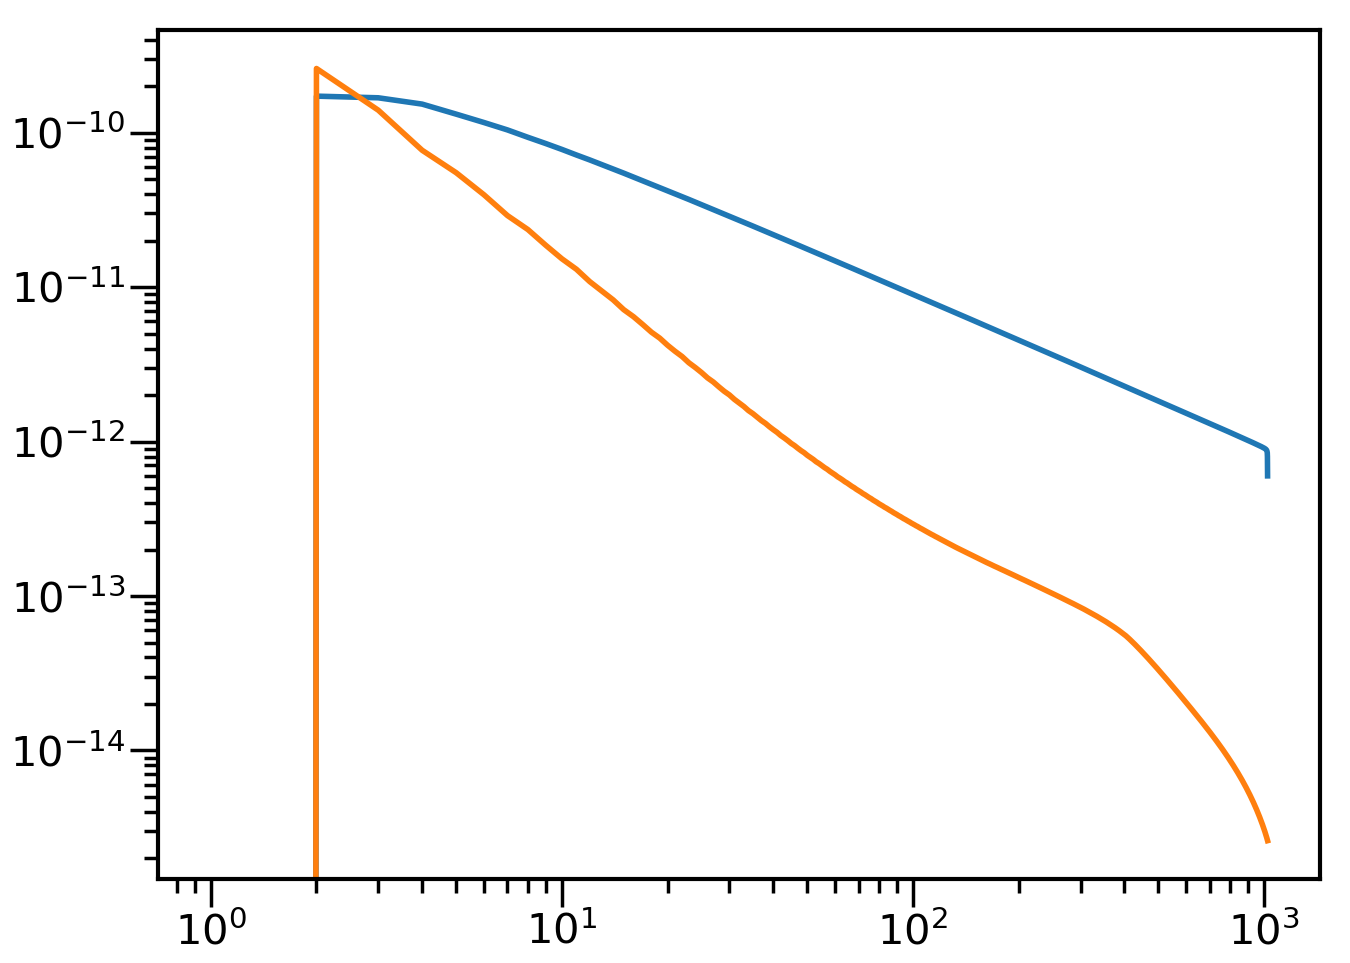

In [102]:
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll])
plot(kappa0.l,(kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M']['shear_B']))
loglog()

11:37:28 WARNING:No handles with labels found to put in legend.


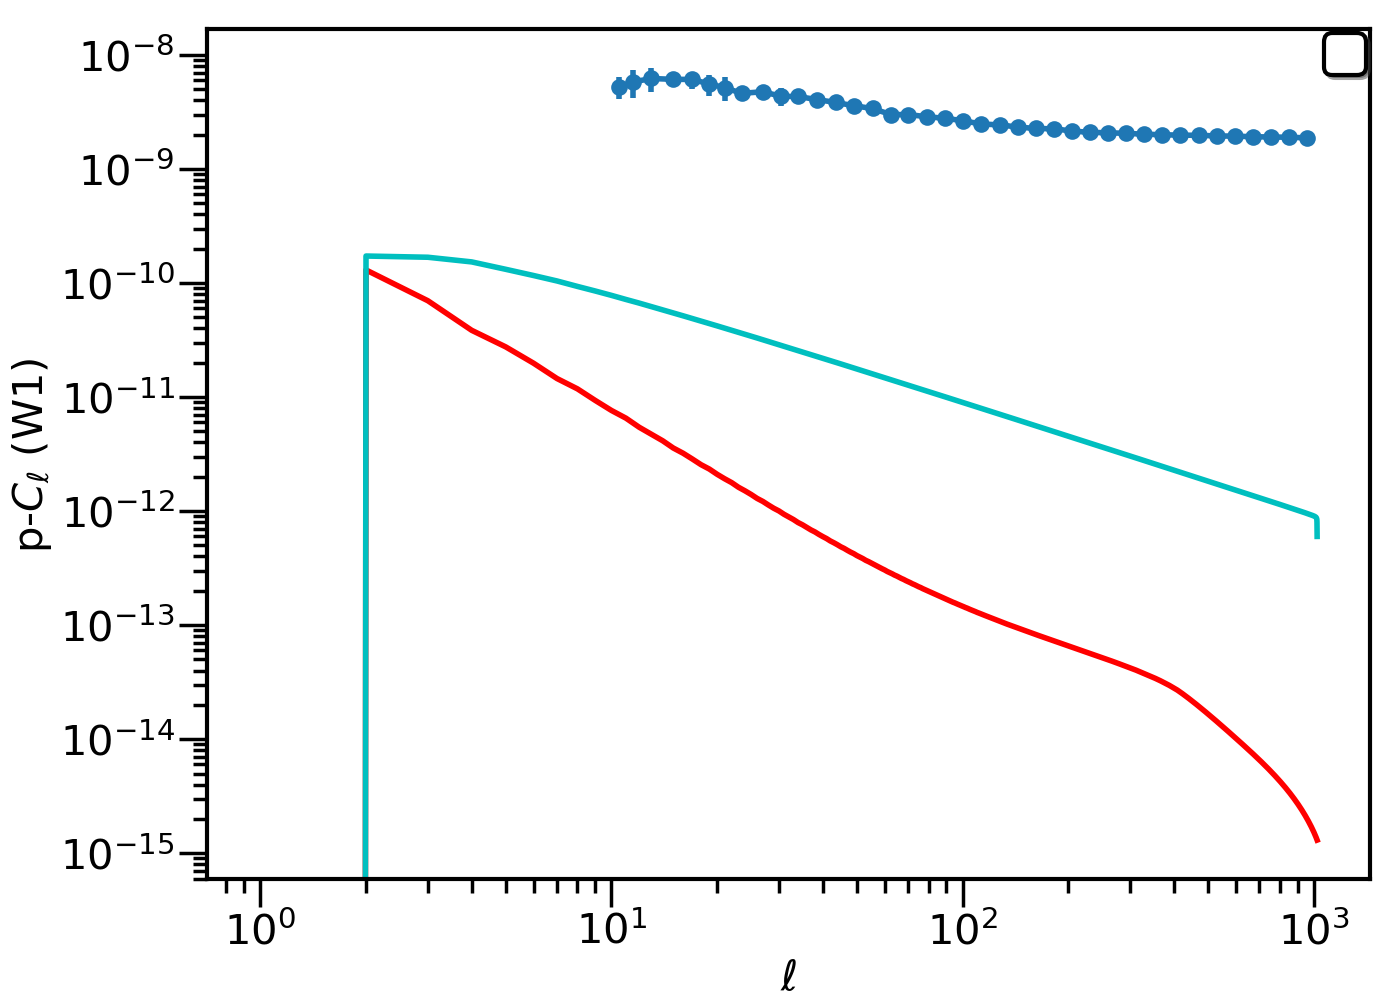

In [99]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in [corr_ll]:
    color=colors[i%len(colors)]
    errorbar(lb,cl_sim_W['clp_b_stats'][corr]['mean']-cl_sim_W['clp0'][corr],cl_sim_W['clp_b_stats'][corr]['std'],fmt='o-',c=color)
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M']['shear_B'],'r-')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll],'c-')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()
# xlim(50,200)
# ylim(1.e-8,1.e-3)

(0.95, 1.3)

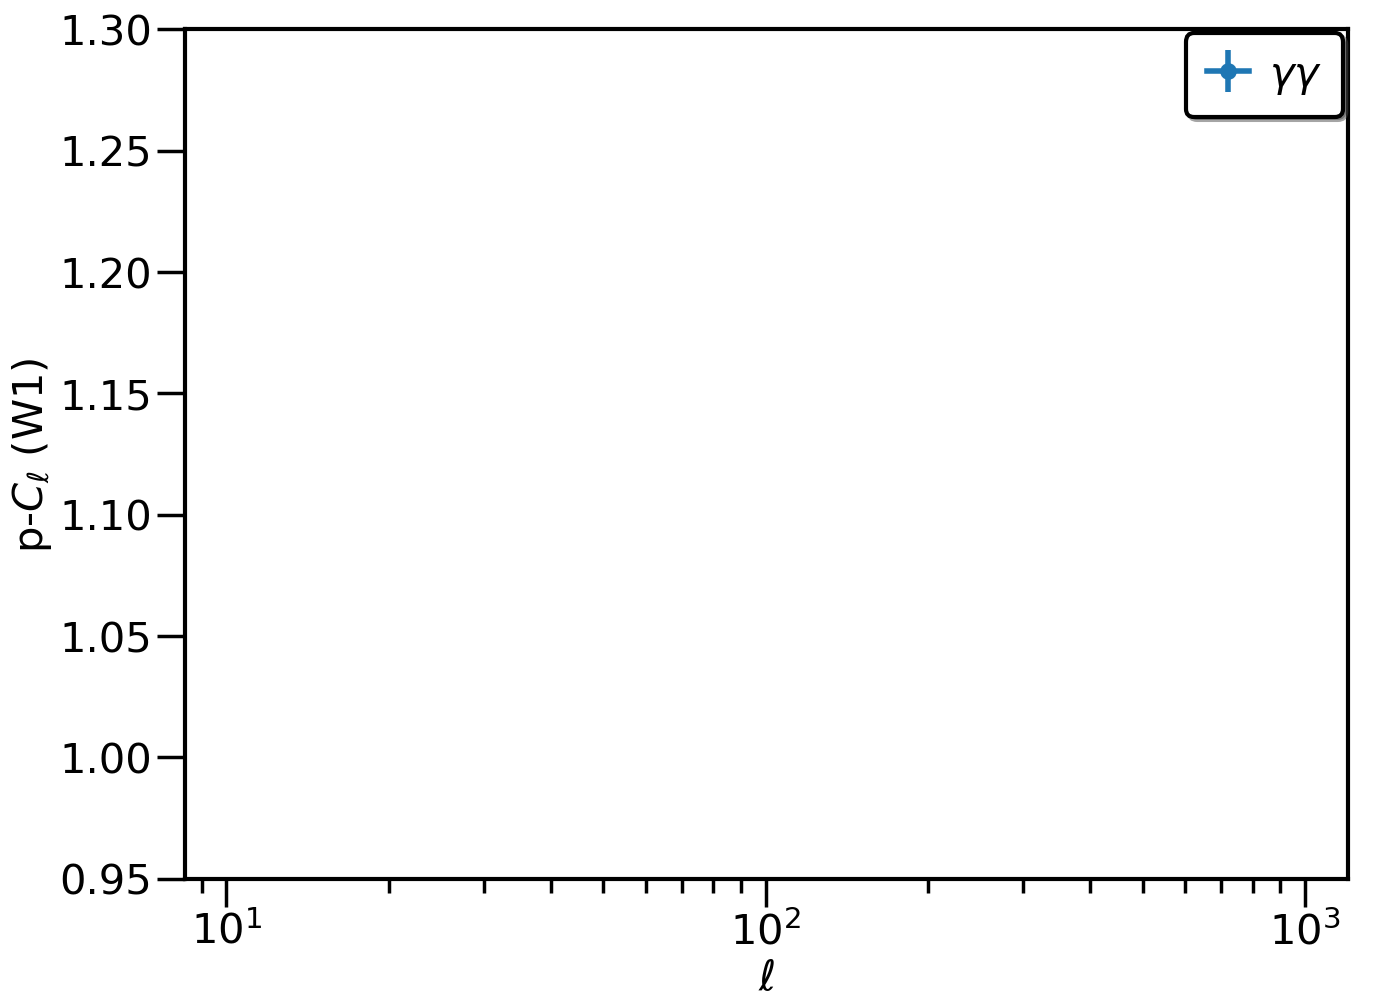

In [100]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
i=0
for corr in [corr_ll]:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),cl_sim_W['clp_b_stats'][corr]['mean']/cl_sim_W['clp0'][corr],cl_sim_W['clp_b_stats'][corr]['std']/cl_sim_W['clp0'][corr],
             fmt='o-',c=color,label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()
ylim(0.95,1.3)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_Ww['clp_b_stats'][corr]['mean'],f*cl_sim_Ww['clp_b_stats'][corr]['std'],fmt='o',c=color)
    errorbar(lb,f*cl_sim_Ww['clp0'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W2)')
# xlim(10,1000)
ylim(1.e-12,1.e-6)
legend()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),cl_sim_Ww['clp_b_stats'][corr]['mean']/cl_sim_Ww['clp0'][corr],cl_sim_Ww['clp_b_stats'][corr]['std']/cl_sim_Ww['clp0'][corr],
             fmt='o',c=color,label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()
ylim(0,2)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in [corr_ll]:
    color=colors[i%len(colors)]
    errorbar(lb,cl_sim_Ww['clp_b_stats'][corr]['mean']-cl_sim_Ww['clp0'][corr],cl_sim_Ww['clp_b_stats'][corr]['std'],fmt='o-',c=color)
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_Ww['coupling_M']['shear_B'],'r-')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_Ww['coupling_M'][corr_ll],'c-')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()
# xlim(50,200)
# ylim(1.e-8,1.e-3)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in [corr_gg]:
    color=colors[i%len(colors)]
    errorbar(lb,cl_sim_Ww['clp_b_stats'][corr]['mean']-cl_sim_Ww['clp0'][corr],cl_sim_Ww['clp_b_stats'][corr]['std'],fmt='o-',c=color)
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
# plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_Ww['coupling_M']['shear_B'],'r-')
plot(kappa0.l,kappa_win.SN[corr_ll][:,0,0]@cl_sim_Ww['coupling_M'][corr_gg],'c-')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),f*cl_sim_Ww['clg_b2_stats'][corr]['mean'],f*cl_sim_Ww['clg_b2_stats'][corr]['std'],fmt='o',c=color)
    plot(lb*(1+i*0.03),f*cl0['cl_b'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$C_\ell$ (W2)')
# xlim(10,1000)
legend()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),f*cl_sim_W['clg_b2_stats'][corr]['mean'],f*cl_sim_W['clg_b2_stats'][corr]['std'],fmt='o',c=color)
    plot(lb*(1+i*0.03),f*cl0['cl_b'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$C_\ell$ (W1)')
# xlim(10,1000)
legend()
ylim(1.e-10,1.e-4)

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
errorbar(lb,cl_sim_Ww['clg_b22_stats'][corr]['mean'],cl_sim_Ww['clg_b22_stats'][corr]['std'],fmt='co')
# plot(lb,cl_sim_Ww['clp_b_stats']['mean']@coupling_Mw_binned2_inv)
plot(lb,cl0['cl_b'][corr])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')

In [ ]:
dl=l_bins[1:]-l_bins[:-1]

In [ ]:
corr=corr_gg
kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['W_pm']

In [ ]:
corr=corr_ll
shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2
coupling_M=kappa_win.Win.Win[corr][(0,0)]['M']
coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_M_inv=np.linalg.inv(coupling_M)
coupling_M_inv=np.zeros_like(coupling_M)
coupling_M_inv[:,cut][cut,:]=np.linalg.inv(coupling_M[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
coupling_M_binned2=kappa_win.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils) #this doesnot work... difference of bin size
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_M_binned2*=dl
coupling_M_binned=bin_coupling_M(kappa_win,coupling_M)
coupling_M_binned_inv=np.linalg.inv(coupling_M_binned)
coupling_M_binned2_inv=np.linalg.inv(coupling_M_binned2)
coupling_M4_binned=bin_coupling_M(kappa_win,coupling_M4)
coupling_M4_binned2=kappa_win.binning.bin_2d(cov=coupling_M4,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4_binned_inv=np.linalg.inv(coupling_M4_binned)

coupling_M_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_M_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
corr

In [ ]:
import copy


In [ ]:
corr=corr_ll

shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2

coupling_Mw=kappa_win_w.Win.Win[corr][(0,0)]['M']
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_Mw_inv=np.linalg.inv(coupling_Mw)
coupling_Mw_inv=np.zeros_like(coupling_Mw)
coupling_Mw_inv[:,cut][cut,:]=np.linalg.inv(coupling_Mw[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_Mw_binned2=kappa_win_w.binning.bin_2d(cov=coupling_Mw,bin_utils=kappa_win_w.cl_bin_utils) #this doesnot work... difference of bin size
coupling_Mw_binned2*=dl
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_Mw_binned=bin_coupling_M(kappa_win_w,coupling_Mw)
coupling_Mw_binned_inv=np.linalg.inv(coupling_Mw_binned)
coupling_Mw_binned2_inv=np.linalg.inv(coupling_Mw_binned2)
coupling_M4w_binned=bin_coupling_M(kappa_win_w,coupling_M4w)
coupling_M4w_binned2=kappa_win.binning.bin_2d(cov=coupling_M4w,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4w_binned_inv=np.linalg.inv(coupling_M4w_binned)

coupling_Mw_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_Mw_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
pcolor(coupling_M_binned2_inv,norm=LogNorm())

In [ ]:
ct=copy.deepcopy(kappa_win_w.Win.Win[corrs[0]][(0,0)]['M'])
pcolor(ct[700:820,700:820],norm=LogNorm())
colorbar()
show()
ct=copy.deepcopy(kappa_win_w.Win.Win[corrs[1]][(0,0)]['M'])
pcolor(ct[700:820,700:820],norm=LogNorm())
colorbar()
show()
ct=copy.deepcopy(kappa_win_w.Win.Win[corrs[2]][(0,0)]['M'])
pcolor(ct[700:820,700:820],norm=LogNorm())
colorbar()

In [ ]:
pcolor(coupling_Mw_binned2*np.gradient(lb),norm=LogNorm())

In [ ]:
dl=l_bins[1:]-l_bins[:-1]

In [ ]:
ct=copy.deepcopy(kappa_win_w.Win.Win[corrs[0]][(0,0)]['M'])
ct=bin_coupling_M(kappa_win_w,ct)
x=ct<1.e-2
ct[x]=0
# ct=np.linalg.inv(ct)
pcolor(ct-coupling_Mw_binned2*np.gradient(lb),norm=LogNorm())
colorbar()

In [ ]:
# yy=np.diag(coupling_M_binned_inv)**2*np.diag(coupling_M4_binned)
yy=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned) * np.gradient(lb)
yy2=np.diag(coupling_M_binned_inv@coupling_M4_binned@coupling_M_binned_inv)
plot(lb,yy)
# plot(lb,1./yy2,'bo')
plot(lb,lb,':')
plot(lb,np.gradient(lb)*(2*lb+1)/2.*f_sky,'--')
xscale('log')
yscale('log')

In [ ]:
Db2=coupling_M_binned_inv@coupling_M4_binned@coupling_M_binned_inv
# D2=coupling_M_inv@coupling_M4@coupling_M_inv

In [ ]:
plot(lb,1./np.diag(Db2))
plot(lb,(2*lb+1)/2*.3)
xscale('log')
yscale('log')

In [ ]:
plot(l,1./np.diag(coupling_M))
plot(l,1./np.diag(coupling_M4))
xscale('log')
yscale('log')

In [ ]:
plot(lb,np.diag(coupling_M_binned))
plot(lb,1./np.diag(coupling_M_binned_inv),'--')
xscale('log')
yscale('log')

In [ ]:
corr=corr_gg

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=lb
errorbar(lb,f*cl_sim_W['clg_b2_stats'][corr]['mean'],f*cl_sim_W['clg_b2_stats'][corr]['std'],fmt='co')
plot(lb,f*cl0['cl_b'][corr])
# plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
# ylim(0,1.e-6)

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=lb
errorbar(lb,f*cl_sim_Ww['clg_b22_stats'][corr]['mean'],f*cl_sim_Ww['clg_b22_stats'][corr]['std'],fmt='co')
plot(lb,f*cl0['cl_b'][corr])
# plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
# ylim(0,1.e-6)

In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clg_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

show()

In [ ]:
cov2=coupling_M_binned_inv@cl0_win['cov'][corr]@coupling_M_binned_inv
cm=corr_matrix(cov_mat=cov2[:500,:500])
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
show()
cm2=corr_matrix(cov_mat=np.real(cl_sim_W['clg_b2_stats'][corr]['cov']))
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

In [ ]:
cov2=coupling_Mw_binned_inv@cl0_win['cov'][corr]@coupling_Mw_binned_inv
cm=corr_matrix(cov_mat=cov2[:500,:500])
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
show()
cm2=corr_matrix(cov_mat=np.real(cl_sim_Ww['clg_b2_stats'][corr]['cov']))
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- sims')
show()
cm2=corr_matrix(cov_mat=cl0_win['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- theory')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')



In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_Ww['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- sims')
show()
cm2=corr_matrix(cov_mat=cl0_win_w['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- theory')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')




In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_stats'][corr]['cov'])[:500,:500])
pcolor(cm,vmin=-1,vmax=1,cmap='seismic')
show()

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(cl0_win['cov'][corr]),'--',label=lbl,color=color)
    lbl=labels[corr]+' sim'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov'])),label=lbl,color=color)
    i+=1
legend()
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+'theory'
    plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--',label=lbl,color=color)
    
    lbl=labels[corr]+'sim'
    plot(lb,np.diag(np.real(cl_sim_W['clg_b2_stats'][corr]['cov'])),label=lbl,color=color)
    i+=1
xscale('log')
yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    i+=1
legend()
xscale('log')
hlines(1,10,2000)
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['clg_b2_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color)
    i+=1
xscale('log')
hlines(1,10,2000)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
plot(lb,np.diag(cl0_win_w['cov'][corr]),'--')
plot(lb,np.diag(np.real(cl_sim_Ww['clp_b_stats'][corr]['cov'])),'-')
xscale('log')
yscale('log')
show()
plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--')
plot(lb,np.diag(np.real(cl_sim_Ww['clg_b22_stats'][corr]['cov'])))
plot(lb,np.diag(np.real(cl_sim_Ww['clg_b2_stats'][corr]['cov'])))
xscale('log')
yscale('log')

show()

plot(lb,np.diag(np.real(cl_sim_Ww['clp_b_stats'][corr]['cov']))/np.diag(cl0_win_w['cov'][corr]),'--')
xscale('log')
# yscale('log')
hlines(1,10,1000)
show()
plot(lb,np.diag(np.real(cl_sim_Ww['clg_b22_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']))
plot(lb,np.diag(np.real(cl_sim_Ww['clg_b2_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']))
xscale('log')
hlines(1,10,1000)
# yscale('log')

In [ ]:
plot(lb,cl_sim_W['clg_b_stats'][corr]['percetile_score'])
plot(lb,cl_sim_W['clg_b2_stats'][corr]['percetile_score'])
xscale('log')
hlines(50,10,1000)

In [ ]:
plot(lb,cl_sim_Ww['clg_b_stats'][corr]['percetile_score'])
plot(lb,cl_sim_Ww['clg_b2_stats'][corr]['percetile_score'],'--')
xscale('log')
hlines(50,10,1000)

In [ ]:
from scipy.stats import wishart,norm,multivariate_normal
from scipy.optimize import minimize
from scipy.stats import entropy,chi2
from scipy.optimize import minimize
def wishart_entropy(df,d):
    if df<1 or not np.isfinite(df):
        return np.inf
    df=df[0]
    m=d.mean()
    
    d=d
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW*=count.max()/pW.max()
#     print(entropy(count,pW),df)
#     crash
    return entropy(count,pW)

In [ ]:
corr=corr_gg
corr_indx=0

In [ ]:
shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2
coupling_M=kappa_win.Win.Win[corr][(0,0)]['M']
coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_M_inv=np.linalg.inv(coupling_M)
coupling_M_inv=np.zeros_like(coupling_M)
coupling_M_inv[:,cut][cut,:]=np.linalg.inv(coupling_M[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
coupling_M_binned2=kappa_win.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils) #this doesnot work... difference of bin size
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_M_binned2*=dl
coupling_M_binned=bin_coupling_M(kappa_win,coupling_M)
coupling_M_binned_inv=np.linalg.inv(coupling_M_binned)
coupling_M_binned2_inv=np.linalg.inv(coupling_M_binned2)
coupling_M4_binned=bin_coupling_M(kappa_win,coupling_M4)
coupling_M4_binned2=kappa_win.binning.bin_2d(cov=coupling_M4,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4_binned_inv=np.linalg.inv(coupling_M4_binned)

coupling_M_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_M_inv,bin_utils=kappa_win.cl_bin_utils)

coupling_Mw=kappa_win_w.Win.Win[corr][(0,0)]['M']
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_Mw_inv=np.linalg.inv(coupling_Mw)
coupling_Mw_inv=np.zeros_like(coupling_Mw)
coupling_Mw_inv[:,cut][cut,:]=np.linalg.inv(coupling_Mw[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_Mw_binned2=kappa_win_w.binning.bin_2d(cov=coupling_Mw,bin_utils=kappa_win_w.cl_bin_utils) #this doesnot work... difference of bin size
coupling_Mw_binned2*=dl
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_Mw_binned=bin_coupling_M(kappa_win_w,coupling_Mw)
coupling_Mw_binned_inv=np.linalg.inv(coupling_Mw_binned)
coupling_Mw_binned2_inv=np.linalg.inv(coupling_Mw_binned2)
coupling_M4w_binned=bin_coupling_M(kappa_win_w,coupling_M4w)
coupling_M4w_binned2=kappa_win.binning.bin_2d(cov=coupling_M4w,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4w_binned_inv=np.linalg.inv(coupling_M4w_binned)

coupling_Mw_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_Mw_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
kappa_win.SN[corr].shape

In [ ]:
df_fit=np.zeros_like(lb)
coupling_M_binned=cl_sim_W['coupling_M_binned'][corr]
# coupling_M4_binned2=cl_sim_W['coupling_M4_binned2'][corr]
for l_i in np.arange(len(lb)):
#     l_i=1
    shot_noise=kappa_win.SN[corr][0,0,0]
#     noise_f=(cl0_win['cl_b'][corr][l_i]+shot_noise)/cl0_win['cl_b'][corr][l_i]
    noise_f=1#(cl0['cl_b'][corr][l_i]+shot_noise)/cl0['cl_b'][corr][l_i] #this should be cl, not p-cl
    df=cl_sim_W['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_M_binned)[l_i]/f_sky
    df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    df=max(1,df)
    df2=max(1,df2)
    df3=max(1,df3)
    
    print(df)

    d=cl_sim_W['clg_b2'][:,l_i,corr_indx]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell',options={'maxiter':1000})
    print(xx.success)
    df_xx=np.float32(xx.x)
    df_fit[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    print(df_xx)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=np.around(df,decimals=2))
    plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pW3,'-.',label=np.around(df3,decimals=2))
    plot(edges_m,pWF,label=np.around(df_xx,decimals=2))
    vlines(m,0,pW.max())
    vlines(cl0['cl_b'][corr][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
    i+=1
#     crash


In [ ]:
noise_f=(cl0['cl_b']+shot_noise)/cl0['cl_b']
df=cl_sim_W['nu_b']/noise_f**2
df2=df*np.diag(coupling_M_binned)/f_sky
df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fit*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
df_fitw=np.zeros_like(lb)
for l_i in np.arange(len(lb)):
#     l_i=1
    noise_f=(cl0['cl_b'][l_i]+shot_noise)/cl0['cl_b'][l_i]
    df=cl_sim_Ww['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_Mw_binned)[l_i]/f_sky
    df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    if df3<1:
        print(df3,df)
        df3=1
#     df=df3[l_i]
    d=cl_sim_Ww['clg_b2'][:,l_i]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    df_fitw[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell=$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=r'$\nu_{(2\ell+1)f_{sky}}=$'+str(np.around(df,decimals=2)))
#     plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pW3,'-.',label=r'$\nu_{win}=$'+str(np.around(df3,decimals=2)))
    plot(edges_m,pWF,label=r'$\nu_{fit}=$'+str(np.around(df_xx,decimals=2)))
#     vlines(m,0,pW.max())
#     vlines(cl0['cl_b'][l_i],0,pW.max(),linestyles='--')
    xlabel(r'$C_{\ell}$')
    legend()
    show()
#     crash

In [ ]:
noise_f=(cl0['cl_b']+shot_noise)/cl0['cl_b']
df=cl_sim_Ww['nu_b']/noise_f**2
df2=df*np.diag(coupling_Mw_binned)/f_sky
df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fitw*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
for l_i in np.arange(len(lb)):
#     l_i=1
    df=cl_sim_W['nu_b'][l_i]/f_sky
    df2=df/np.diag(coupling_M_binned_inv)[l_i]#/f_sky
    d=cl_sim_W['clp_b'][:,l_i]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=1,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=np.around(df,decimals=2))
    plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pWF,label=np.around(df_xx,decimals=2))
    vlines(m,0,pW.max())
    vlines(cl0_win['cl_b'][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
#     crash